# CAP 4611: Homework 2



In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part I - The Dataset
This assignemnt features the glass dataset from UCI's ML repository. This dataset consists of 214 datapoints, each with 9 features *(#2-10 below)*. The following is a description of the elements for each datapoint, from the repository's description file `glass.names`:

1. ID: Each datapoint is given a unique id from 1-214.
2. RI: Refractive index
3. Na: Sodium
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (the classes)
      - 1: building_windows_float_processed
      - 2: building_windows_non_float_processed
      - 3: vehicle_windows_float_processed
      - 4: vehicle_windows_non_float_processed (none in this database)
      - 5: containers
      - 6: tableware
      - 7: headlamps

In [84]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
feature_names = ["id","RI","Na","Mg","Al","Si","K","Ca","Ba","Fe","glass_type"]
class_names = ["building_windows_fp","building_windows_nfp","vehicle_windows_fp",
               "vehicle_windows_nfp","containers","tableware","headlamps"]
glass_dataset = pd.read_csv(url, names=feature_names)
print(glass_dataset)

      id       RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  glass_type
0      1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0           1
1      2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0           1
2      3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0           1
3      4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0           1
4      5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0           1
..   ...      ...    ...   ...   ...    ...   ...   ...   ...  ...         ...
209  210  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0           7
210  211  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0           7
211  212  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0           7
212  213  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0           7
213  214  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0           7

[214 rows x 11 columns]


This will get rid of the useless information (the id) and separate the features from the class labels.

In [85]:
np_glass = glass_dataset.values
features = np_glass[:,1:10]
labels = np_glass[:,10]

## Part II - Class Priors and Entropy
Now we can calculate the priors for each class...

In [86]:
class_cnt = np.array([np.count_nonzero(labels == i) for i in range(1,8)])
r,c = np_glass.shape
priors = class_cnt * 1.0/r

print(priors)

[0.3271028  0.35514019 0.07943925 0.         0.06074766 0.04205607
 0.13551402]


The priors for this set infer that there are many more examples of building windows than any other class (~70% between the two classes), thus making this set *unbalanced*. Also, the fourth class is completely absent from this dataset, representing the most extreme case of unbalancing.

Let's see the resulting uncertainness (entropy) of the distribution:

In [87]:
with np.errstate(divide='ignore'):
  entropies = -priors * np.nan_to_num(np.log2(priors), nan=0)
print("Class Entropies: {}\n".format(entropies))
print("Entropy of Class Prior Distribution: {}".format(sum(entropies)))

Class Entropies: [0.5273499  0.53041589 0.29027136 0.         0.24548296 0.19226111
 0.39075277]

Entropy of Class Prior Distribution: 2.176533992398201


## Part III: Gaussian Fitting and Naive Bayes

In order to learn more about the relationship between the data for each class, now we can fit a gaussian curve for each of the features in the classes. This will done in accordance to their means and standard deviations. The splitting of the classes uses a handy trick from [StackOverflow](https://stackoverflow.com/questions/31863083/python-split-numpy-array-based-on-values-in-the-array "Split Numpy Array Based on Values in the Array"), which works since the data is already sorted by label.

In [88]:
split_features = np.split(features, np.where(np.diff(labels))[0]+1)

# Creates a dictionary with the DataFrames for the respective classes
gaus_features = {}
for i in range(1,8):
  # Creates an empty dataframe for the fourth element
  if i == 4:
    gaus_features[i] = pd.DataFrame(data=np.zeros(shape=(9,2)),
                                    columns=['mean','sd'],
                                    index=feature_names[1:10])
  else:
    indx = i-1 if i < 4 else i-2
    np_df = np.zeros(shape=(9,2))
    # Gets the means for each feature
    np_df[:,0] = np.mean(split_features[indx],axis=0)
    # Gets the standard deviations for each feature
    np_df[:,1] = np.std(split_features[indx],axis=0)
    # Puts them into a DataFrame
    gaus_features[i] = pd.DataFrame(data=np_df,columns=['mean','sd'],
                                    index=feature_names[1:10])

We can now print out the results as such:

In [89]:
for i in range(7):
  print("{0}. {1}:".format(i+1,class_names[i]))
  print(gaus_features[i+1])
  print()

1. building_windows_fp:
         mean        sd
RI   1.518718  0.002252
Na  13.242286  0.495722
Mg   3.552429  0.245272
Al   1.163857  0.271200
Si  72.619143  0.565402
K    0.447429  0.213339
Ca   8.797286  0.570686
Ba   0.012714  0.083237
Fe   0.057000  0.088436

2. building_windows_nfp:
         mean        sd
RI   1.518619  0.003777
Na  13.111711  0.659775
Mg   3.002105  1.207637
Al   1.408158  0.316239
Si  72.598026  0.719790
K    0.521053  0.212315
Ca   9.073684  1.908951
Ba   0.050263  0.359949
Fe   0.079737  0.105730

3. vehicle_windows_fp:
         mean        sd
RI   1.517964  0.001859
Na  13.437059  0.491753
Mg   3.543529  0.157926
Al   1.201176  0.337114
Si  72.404706  0.496981
K    0.406471  0.223026
Ca   8.782941  0.368762
Ba   0.008824  0.035294
Fe   0.057059  0.104643

4. vehicle_windows_nfp:
    mean   sd
RI   0.0  0.0
Na   0.0  0.0
Mg   0.0  0.0
Al   0.0  0.0
Si   0.0  0.0
K    0.0  0.0
Ca   0.0  0.0
Ba   0.0  0.0
Fe   0.0  0.0

5. containers:
         mean        sd
R

As an example of how knowing these values can help in predictions, let's take the case where we had a sample feature $x=0.2$ from a gaussian distribution with mean $\mu=0.5$, standard deviation $\sigma=0.1$. We can find the _probability density function_ (PDF) value corresponding to $x$:

In [90]:
from scipy.stats import norm

x = 0.2
mu = 0.5
sigma = 0.1

print("{:.5f}".format(norm.pdf(x,mu,sigma)))

0.04432


Now why is this useful? Let's take a look at what a naive Bayes model would tell us. The probability of some sample belonging to a class is defined in the model to be the product between the **class prior** and of the **product of all the PDFs of the features**.

For example, let's say we had 2 classes, Class $A$ and Class $B$. Class $A$ has a prior of 0.6 while Class $B$ has a prior of 0.4. These two classes have features of _height_ and _width_. Also, the following is true for each feature:

<ul>
Height Class $A$: mean 0.5, standard deviation of 0.1

Height Class $B$: mean 0.2, standard deviation of 0.1

Width Class $A$ : mean 0.7, standard deviation of 1

Width Class $B$: mean 0.3, standard deviation of .2
</ul>

Now, using naive Bayes, let's see how we would classify a new object that had height of 0.2m and width of 0.7m.

(Notice how the height of Class $A$ matches with the previous example, and how the height of the new object is also 0.2!)

In [91]:
# Define Class A
prior_a = 0.6
height_a = (0.5,0.1)
width_a = (0.7,1)
# Define Class B
prior_b = 0.4
height_b = (0.2,0.1)
width_b = (0.3,0.2)

# Define New Object (Height, Width)
new_object = (0.2,0.7)

# Calculates Probability of being in either class
prob_a = (prior_a *
          norm.pdf(new_object[0],height_a[0],height_a[1]) *
          norm.pdf(new_object[1],width_a[0],width_a[1]))
print("Probability of Class A: {:.5f}".format(prob_a))
prob_b = (prior_b *
          norm.pdf(new_object[0],height_b[0],height_b[1]) *
          norm.pdf(new_object[1],width_b[0],width_b[1]))
print("Probability of Class B: {:.5f}".format(prob_b))

Probability of Class A: 0.01061
Probability of Class B: 0.43079


Thus, we would choose class $B$ in this case.

## Part IV: Support Vector Machines

Rather than doing something like the Naive Bayes classifier on the Glass Dataset, let's use something that is better suited to real world use. Support Vector Machines (SVMs) are a great tool for providing good classification on a dataset.

As with any classification set, it is good to divide the data into a _training_ and _testing_ set randomly. However, for this assignment, a random state is hard-coded to allow for consistent results.

In [92]:
from sklearn.model_selection import train_test_split

# Splits the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=8290)

Now we can fit the model...

In [93]:
from sklearn import svm

glass_model = svm.SVC(kernel='linear',C=5,gamma='auto')
glass_model.fit(X_train, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

... and get the accuracy of the model on the testing set.

In [94]:
from sklearn.metrics import accuracy_score

y_pred = glass_model.predict(X_test)
lin_acc = accuracy_score(y_pred,y_test)

print("Linear SVM Accuracy: {:.5f}%".format(100*lin_acc))

Linear SVM Accuracy: 65.11628%


Let's compare that to using a different type of kernel for the separation of data, specifically the _radial basis function_.

In [95]:
# Creates new model with radial basis function
glass_model = svm.SVC(kernel='rbf',C=5,gamma='auto')
glass_model.fit(X_train, y_train)

# Gets accuracy of the model
y_pred = glass_model.predict(X_test)
rbf_acc = accuracy_score(y_pred,y_test)

print("RBF SVM Accuracy: {:.5f}%".format(100*rbf_acc))

RBF SVM Accuracy: 76.74419%


In this case, using the radial basis function yielded a higher accuracy on the model.

In keeping with the RBF model, we can show the results in a different way. _Confusion Matrices_ are a popular way to represent not only the correctness of the model, but to also see what the misclassifications were.

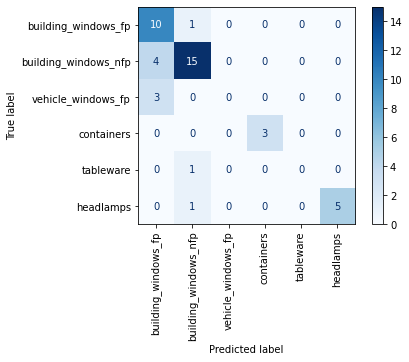

In [96]:
from sklearn.metrics import plot_confusion_matrix

# Since the 4th class wasn't trained on, it wouldn't show in the training or
# the confusion matrix. Thus, it needs to be removed.
class_names_ = class_names[:3] + class_names[4:]

cf = plot_confusion_matrix(glass_model,X_test,y_test,xticks_rotation=90,
                           display_labels=class_names_,cmap='Blues')

## Part V: Improving SVM Accuracy

Even though Sklearn gives us the ability to automatically find the best value of C, we can do so manually. Let's create a plot of accuracies based on these C values.

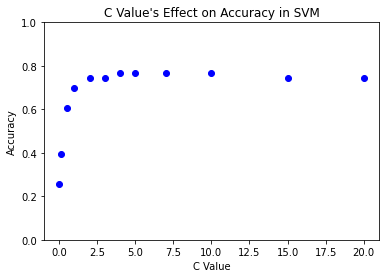

In [97]:
# Values of C to iterate through
C = [0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20]

# Get the accuracy of each C value
accs = []
for c in C:
  model = svm.SVC(kernel='rbf',C=c,gamma='auto')
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  accs.append(accuracy_score(y_test,y_pred))

# Plots the C's and their accuracies
plt.plot(C, accs, 'bo')
plt.ylim(0.0,1.0)
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.title("C Value's Effect on Accuracy in SVM")
plt.show()

We can also see which C value(s) achieved the highest accuracy.

In [98]:
indics = np.where(accs == np.amax(accs))[0]
print([C[i] for i in indics])

[4, 5, 7, 10]


These C values give the best accuracy in this SVM model.

Back to the RBF model, we can see the support vectors that were chosen by the model.

In [99]:
print(glass_model.support_vectors_)

[[1.51720e+00 1.33800e+01 3.50000e+00 ... 8.43000e+00 0.00000e+00
  0.00000e+00]
 [1.51775e+00 1.28500e+01 3.48000e+00 ... 8.56000e+00 9.00000e-02
  2.20000e-01]
 [1.51736e+00 1.27800e+01 3.62000e+00 ... 8.70000e+00 0.00000e+00
  0.00000e+00]
 ...
 [1.51508e+00 1.51500e+01 0.00000e+00 ... 8.34000e+00 6.30000e-01
  0.00000e+00]
 [1.51556e+00 1.38700e+01 0.00000e+00 ... 9.41000e+00 8.10000e-01
  1.00000e-02]
 [1.52315e+00 1.34400e+01 3.34000e+00 ... 8.83000e+00 0.00000e+00
  0.00000e+00]]


Looking back at the confusion matrix for the RBF kernel model, we can see that other classes were misclassified as the building_windows_fp class many times. One idea to improve the model would be to re-weight the samples that belong to this class.

In [100]:
# Creates weights of default 1
weights = np.ones(y_train.shape)
# Re-weights all examples where that class is
weights[np.where(y_train == 1)] = 0.8

# Creates new model with the new weights
glass_model = svm.SVC(kernel='rbf',C=5,gamma='auto')
glass_model.fit(X_train, y_train, sample_weight=weights)

# Gets accuracy of the model
y_pred = glass_model.predict(X_test)
rbf_acc = accuracy_score(y_pred,y_test)

print("RBF SVM Weighted Accuracy: {:.5f}%".format(100*rbf_acc))

RBF SVM Weighted Accuracy: 81.39535%


... and see the effect that has on the confusion matrix...

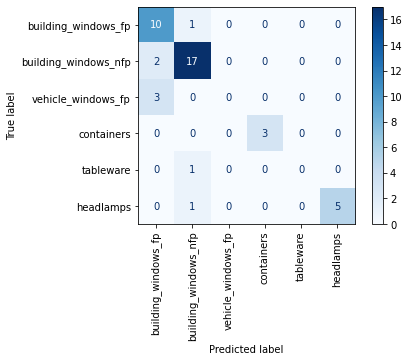

In [101]:
cf = plot_confusion_matrix(glass_model,X_test,y_test,xticks_rotation=90,
                           display_labels=class_names_,cmap='Blues')

Lowering the importance of that class reasonably has shown a sizeable improvement in the accuracy. However, manipulation of the model parameters (in this case, weights) to influence the test set must be done so with great caution... this could lead to overfitting the test set.